In [1]:
import pandas as pd
import numpy as np
import math
from QuantLib import *
import scipy as sp
import scipy.stats as si
import statsmodels.api as sm
import pandas_datareader
import sklearn
from sklearn.decomposition import PCA, KernelPCA
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.arima.model import ARIMA
from sklearn import datasets , linear_model
from tabulate import tabulate
from pandas_datareader import data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sympy as sy
import k3d
from sympy.stats import Normal, cdf
import urllib.request
import zipfile

import time
import warnings
warnings.filterwarnings("ignore")
import pandas_market_calendars as mcal
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

In [2]:
class Data:
    
    def __init__(self, startDate, endDate,csv):
        #startDate = starting date for our data
        #endDate = ending date for out data
        self.startDate = startDate
        self.endDate = endDate
        self.csv = csv
        #super().__init__(startDate, endDate)
        
    # function to import the .csv file and apply any dates of interest
    def ImportDataFrame(self):
        df = pd.read_csv(self.csv)
        df.index = pd.to_datetime(df['Date'])
        #df = df.loc[self.startDate : self.endDate]
        return df
    
    def Statistics(self, df):
        plt.figure(figsize = (9,7))
        plt.title('Correlation Matrix',fontsize=20)
        sns.heatmap(df.corr(), cmap="Reds", annot=False,fmt='.2g')
        plt.show()
        plt.figure(figsize = (9,7))
        plt.title('Covariance Matrix',fontsize=20)
        sns.heatmap(df.cov(), cmap="Blues", annot=False,fmt='.2g')
        plt.show()
        #print(tabulate(df.describe(), tablefmt='github'))
        return 
        

In [3]:
# curve tenors by Bloomberg classification
I23 = [0.25,0.3,0.5,0.75,1,1.25,1.5,2,3,4,5,6,7,8,9,10,15,20,30,40,50]
I206 = [0.06,0.125,0.25,0.3,0.5,0.75,1]
I203 = [3,4,5,6,7,8,9,10,15,20,25,30]
# creating data frames and cleaning data

start_date = '2010-01-01'
end_date = '2021-11-01'
data = Data(start_date, end_date,'CurveData.csv')
MasterDF = data.ImportDataFrame()
#for col in MasterDF.columns:
#    print(col)
#print(MasterDF.head())

# the dataframe  to walk forward with**********************************************************
data2 = Data(start_date, end_date,'walkForward.csv')
walkForwardDF = data2.ImportDataFrame()
#print(walkForwardDF.head(5))
#**********************************************************************************************

walkfCurve = walkForwardDF[["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3","USSWAP2","USSAWP3","USSAWP4","USSAWP5","USSW6","USSAWP7","USSW8","USSW9","USSAWP10","USSAWP15","USSAWP20","USSAWP30",'USSAWP40','USSAWP50']]
walkfCurve = walkfCurve.dropna()


DiscountCurve = MasterDF[["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3","USSWAP2","USSAWP3","USSAWP4","USSAWP5","USSW6","USSAWP7","USSW8","USSW9","USSAWP10","USSAWP15","USSAWP20","USSAWP30",'USSAWP40','USSAWP50']]
DiscountCurve = DiscountCurve.dropna()

SwapCurve =  walkForwardDF[["USSWAP2","USSAWP3","USSAWP4","USSAWP5","USSW6","USSAWP7","USSW8","USSW9","USSAWP10","USSAWP15","USSAWP20","USSAWP30"]]
SwapCurve = SwapCurve.dropna()
SwapCurveCopy = SwapCurve.copy()

LiborCurve = MasterDF[["O/N Libor","1W Libor","1M Libor","2M Libor","3M Libor","6M Libor","12M Libor"]]
LiborCurve = LiborCurve.dropna()

In [4]:
class FuturesTransform:
    
    def __init__(self, T_1, T_2, df):
        # T_1 = the time t_1 that the forward rate agreement would start at
        # T_2 = the time t_2 that the Forward rate would be, in our case either 3- or 1-month as a fraction of a year
        # df is the data frame of futures
        self.T_1 = T_1
        self.T_2 = T_2
        self.df = df
        
    def convertToRate(self):
        self.df = self.df[["EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"]]
        # rate = (100 - EDF price) / 100
        for col in self.df.columns:
            for index, row in self.df.iterrows():
                row[col] = (100 - row[col])/100
                
        return self.df     
        
    def HullWhiteConvexityAdjustment(self, df):
        #vol = self.df.var()* np.sqrt(2) /100
        for col in df.columns:
            vol = df[col].var() 
            std = df[col].std()
            self.T_2 = self.T_1 + 0.25
            for index, row in self.df.iterrows():
                row[col] = (row[col] - ((0.5 * vol * self.T_1 * self.T_2)))
            self.T_1 += 0.25
        return df
    
    def ForwardToSpot(self, df):
        #lstTickers = ["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"]
        Spotdf = df[["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"]]
        #3M forward
        for index, row in Spotdf.iterrows():
            row['EDZ1'] = (((1+row['EDH2'])**0.25) * ((1+row["3M Libor"])**0.25))**(1/(0.25 + 0.25)) -1
        #6M forward
        for index, row in Spotdf.iterrows():
            row['EDH2'] = (((1+row['EDH2'])**(7/12))*((1+row["3M Libor"])**0.25))**(1/(0.25 + 7/12)) - 1
        #10M forward
        for index, row in Spotdf.iterrows():
            row['EDM2'] = (((1+row['EDM2'])**(3/12))*((1+row['EDH2'])**0.5))**(1/(0.5 + 3/12)) - 1
        #13M forward
        for index, row in Spotdf.iterrows():
            row['EDU2'] = (((1+row['EDU2'])**(3/12))*((1+row['EDM2'])**(10 / 12)))**(1/(3/12 + 10/12)) - 1
        #15M forward
        for index, row in Spotdf.iterrows():
            row['EDZ2'] = (((1+row['EDZ2'])**(3/12))*((1+row['EDU2'])**(13 / 12)))**(1/(0.25 + 13/12)) - 1
        #19M forward
        for index, row in Spotdf.iterrows():
            row['EDH3'] = (((1+row['EDH3'])**(3/12))*((1+row['EDZ2'])**(15 / 12)))**(1/(0.25 + 15/12)) - 1
        
        return Spotdf

In [5]:
futures = FuturesTransform(24/360, 0.0, DiscountCurve)
futuresRates = futures.convertToRate()

forwardRates = futures.HullWhiteConvexityAdjustment(futuresRates)

DiscountCurveCopy = DiscountCurve.drop(["EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"], axis=1)
DiscountCurveCopy = DiscountCurveCopy/100
DiscountCurveAdjusted = pd.concat([DiscountCurveCopy, forwardRates], axis=1)
#print(DiscountCurveAdjusted.head(2))
spotrates = futures.ForwardToSpot(DiscountCurveAdjusted) 

SpotCurve = DiscountCurveAdjusted.drop(["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"], axis=1)
SpotCurve = pd.concat([spotrates, SpotCurve], axis=1)
SpotCurve.head(2)

# process to convert the walk forward df
WFfutures = FuturesTransform(24/360, 0.0, walkfCurve)
WFfuturesRates = WFfutures.convertToRate()
WFforwardRates = WFfutures.HullWhiteConvexityAdjustment(WFfuturesRates)
walkfCurveCopy = walkfCurve.drop(["EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"], axis=1)

walkfCurveCopy = walkfCurveCopy/100
#print(walkfCurveCopy.head(20))
walkfCurveAdjusted = pd.concat([walkfCurveCopy, WFforwardRates], axis=1)
#print(walkfCurveAdjusted.head(20))
walkfCurveAdjusted = walkfCurveAdjusted[["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3","USSWAP2","USSAWP3","USSAWP4","USSAWP5","USSW6","USSAWP7","USSW8","USSW9","USSAWP10","USSAWP15","USSAWP20","USSAWP30",'USSAWP40','USSAWP50']]

WFsportrates = WFfutures.ForwardToSpot(walkfCurveAdjusted) 

WFcurve = walkfCurveAdjusted.drop(["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"], axis=1)
WFcurve = pd.concat([WFsportrates,WFcurve], axis=1)

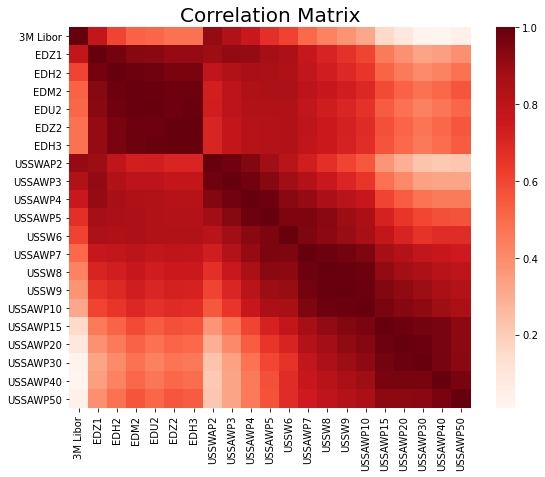

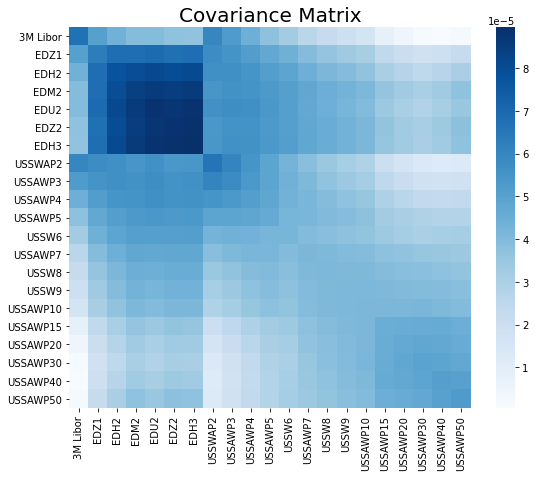

<AxesSubplot:title={'center':'Curve Time Series Data'}, xlabel='Dates', ylabel='Yields'>

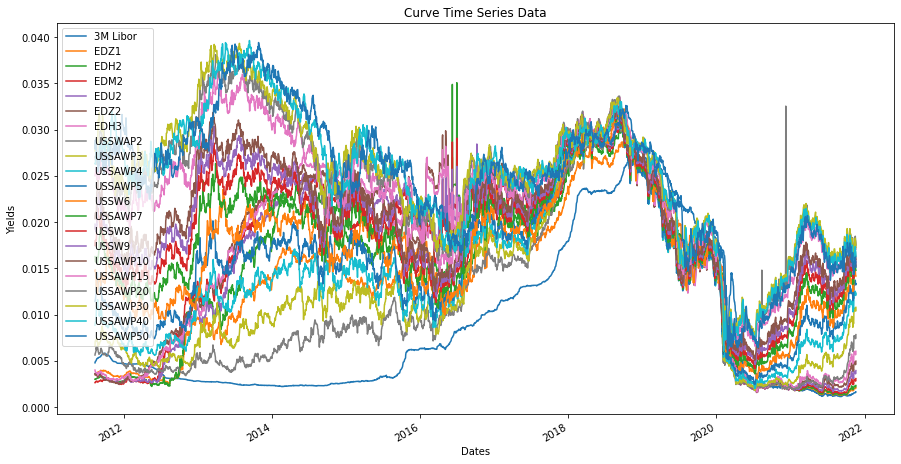

In [6]:
DiscountCurveAdjusted = DiscountCurveAdjusted[["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3","USSWAP2","USSAWP3","USSAWP4","USSAWP5","USSW6","USSAWP7","USSW8","USSW9","USSAWP10","USSAWP15","USSAWP20","USSAWP30",'USSAWP40','USSAWP50']]
#CurveMatrix = data.Statistics(DiscountCurveAdjusted)
#DiscountCurveC = DiscountCurve.loc['2012-01-01':'2021-11-01']
#DiscountCurveAdjusted.plot(figsize = (15,7))


# above repeated with spot curve
SpotCurveMatrix = data.Statistics(SpotCurve)
#print(tabulate(SpotCurveMatrix, tablefmt='github'))    
SpotCurve.plot(figsize = (15,8),title='Curve Time Series Data',xlabel='Dates',ylabel='Yields')

In [7]:
class PCAAnalysis:
    
    def __init__(self,df,reconstruct):
        # df = dataFrame
        # reconstruct = the rates that have to reconstructed (12) input or 21
        self.df = df
        self.reconstruct = reconstruct
            
    def PCA(self):
        self.df -= self.df.mean(axis=0)
        Matrix = np.cov(self.df, rowvar=False)
        eigenvalues, eigenvectors = sp.linalg.eigh(Matrix)
        #print('eig vals: ',eigenvalues)
        eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
        eigenvalues = eigenvalues[np.argsort(eigenvalues)[::-1]]
        eigenvectors = eigenvectors[:, :self.reconstruct]
        
        return np.dot(eigenvectors.T, self.df.T).T, eigenvalues, eigenvectors 
    
    def PlotEigenvectors(self,vectors,components):
        # vectors is the simply the matrix of eignevectors
        # components is the number of components that we want to plot
        vectors = pd.DataFrame(vectors)
        plt.plot(vectors.iloc[:,0],label=f'PC{1} Parallel Shift')
        plt.plot(vectors.iloc[:,1],label=f'PC{2} Slope Shift')
        plt.plot(vectors.iloc[:,2],label=f'PC{3} Curvature')
        plt.plot(vectors.iloc[:,3],label=f'PC{4}')
        plt.title("Yield Curve Components")
        plt.ylabel("Eigenvector Values")
        plt.xlabel("Eigenvectors")
        plt.legend()
        plt.show()
        return vectors
    
    def rebuild(self):
        #print(SwapCurve.tail())
        rebuilt = pd.DataFrame(np.dot(scores,eigenvecs.T), index=SpotCurve.index, columns=SpotCurve.columns)
        for cols in rebuilt.columns:
            rebuilt[cols] = rebuilt[cols] + SpotCurve.mean(axis=0)[cols]
            #print(rebuilt[cols])
            #print(SwapCurve.mean(axis=0)[cols])
        plt.plot(rebuilt)
        plt.ylabel("Rates")
        plt.title("Reconstructed Curve Data")
        plt.show()
        return rebuilt
###########################################################################################################################    
    def sklearnPCA(self):
        
        skPCA = PCA(n_components=10)
        skPCA.fit(SpotCurveCopy)
        PCA(copy=True,iterated_power='auto',n_components=4,random_state=None,svd_solver='auto',tol=0.0,whiten=False)
        print(skPCA.explained_variance_ratio_[0:4]) 
        dfskpca = pd.DataFrame(skPCA.transform(SpotCurveCopy))
        dfskpca.index = SpotCurveCopy.index
        #print(dfskpca.head(2))

        plt.plot(skPCA.explained_variance_ratio_[0:4])
        plt.title("Eigen Value Decomposition of Variance")
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance")
        plt.show()
        
        
        plt.plot(skPCA.components_[0:4].T)
        plt.xlabel("Principal Component")
        plt.show()

        vals = skPCA.transform(SpotCurveCopy)
        plt.plot(vals[:,0:10])
        plt.show()
        return

[0.74368025 0.16830916 0.06458284 0.011132  ]


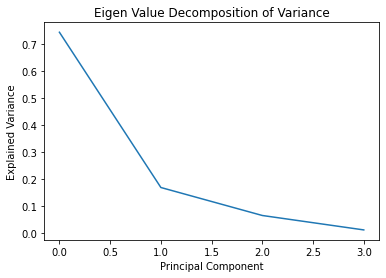

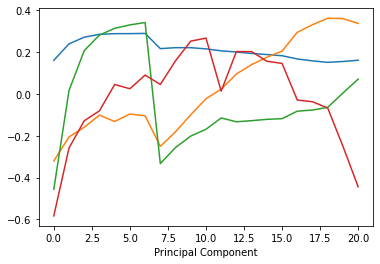

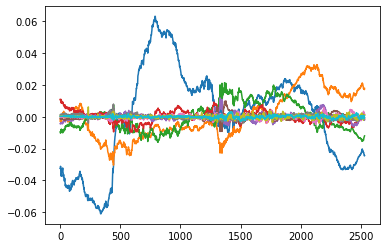

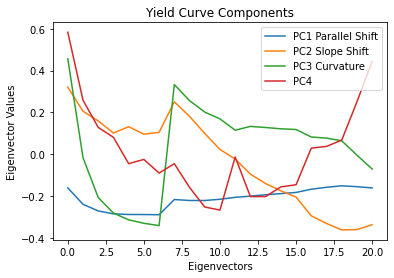

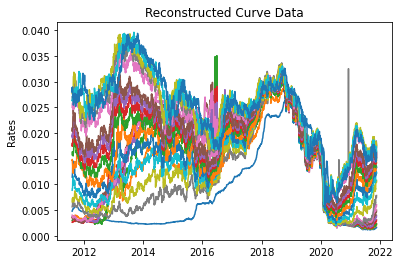

eigen values:  0.0012334129498685058


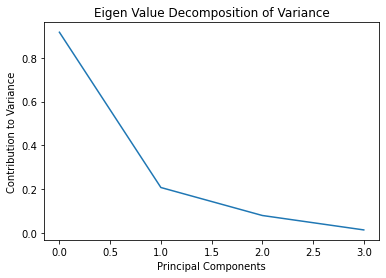

[0.91726485 0.20759469 0.07965732 0.01373035]


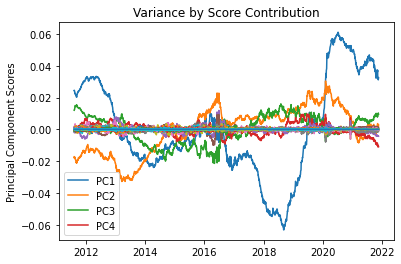

In [8]:
SpotCurveCopy = SpotCurve.copy()
pca = PCAAnalysis(SpotCurveCopy,21)

sk = pca.sklearnPCA()

scores, eigenvals, eigenvecs = pca.PCA()
graph = pca.PlotEigenvectors(eigenvecs,3)
rebuild = pca.rebuild()

print('eigen values: ', sum(eigenvals))
plt.plot(eigenvals[0:4]*1000)
plt.title("Eigen Value Decomposition of Variance")
plt.ylabel("Contribution to Variance")
plt.xlabel("Principal Components")
plt.show()
print(1000*eigenvals[0:4])


scores = pd.DataFrame(np.dot(eigenvecs.T, SpotCurveCopy.T).T, index=SpotCurveCopy.index, columns=SpotCurveCopy.columns)
#scores.plot(figsize = (12,7))
plt.plot(scores.iloc[:,0],label=f'PC{1}')
plt.plot(scores.iloc[:,1],label=f'PC{2}')
plt.plot(scores.iloc[:,2],label=f'PC{3}')
plt.plot(scores.iloc[:,3],label=f'PC{4}')
plt.plot(scores.iloc[:, 4:])
plt.ylabel("Principal Component Scores")
plt.title("Variance by Score Contribution")
plt.legend()
plt.show()
# test with short and mid
spotratescopy = spotrates.copy()

#pca1 = PCAAnalysis(LiborCurve,7)
#scores1, eigenvals1, eigenvecs1 = pca1.PCA()
#graph1 = pca1.PlotEigenvectors(eigenvecs1,3)
#rebuild1 = pca.rebuild()

In [9]:
class Splines:
    
    def __init__(self, lstTenors, curveDF, curveSlice):
        # lstTenors = the tenors of the curve that we want to build
        # curveDF = the dataFrame that we contains the specific curve data
        # curveSlice = the time period of the curve that we want to display, (0 = most recent day)
        self.lstTenors = lstTenors
        self.curveDF = curveDF
        self.curveSlice = curveSlice
        
    def Cubic(self):
        from scipy.interpolate import CubicSpline
        x = self.lstTenors
        y = self.curveDF.iloc[self.curveSlice]
        cubic = CubicSpline(x,y)
        return cubic, y
        
    
    def interpolate(self, fittedcurve,marker,mcol,spline,curve):
        points = np.linspace(min(self.lstTenors),max(self.lstTenors),100)
        #plt.figure(figsize=(18, 5))
        #plt.title('Yield Curve from Cubic Spline', fontsize = 15)
        plt.xlabel('Time to Maturity (in Years)',fontsize = 15)
        plt.ylabel('Yields in Basis Points',fontsize = 15)
        plt.plot(self.lstTenors, self.curveDF.iloc[self.curveSlice],marker,color=mcol,label=f'{curve}')
        plt.plot(points, fittedcurve(points), linewidth=2,color=spline,label=f"Cubic Spline ({curve})")
        plt.grid(linestyle = '--', linewidth = 1)
        plt.legend(loc='lower right', ncol=1)
        return #visual
    
    def Spread(self, curve1, curve2):
        spread = pd.DataFrame(curve1 - curve2)
        yields = pd.DataFrame(curve1)
        return print(tabulate(spread,headers=['Tenors','Spread(bps)'],tablefmt='github',floatfmt=".8f")), yields
        

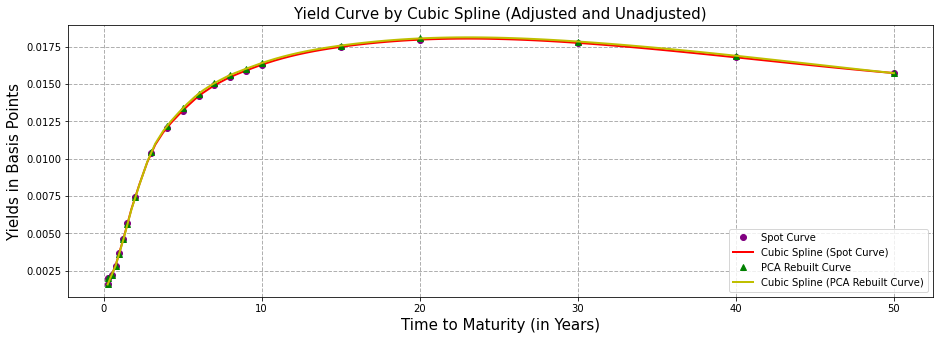

| Tenors   |   Spread(bps) |
|----------|---------------|
| 3M Libor |    0.00002130 |
| EDZ1     |    0.00001065 |
| EDH2     |    0.00000639 |
| EDM2     |    0.00002091 |
| EDU2     |    0.00005062 |
| EDZ2     |    0.00005051 |
| EDH3     |    0.00003384 |
| USSWAP2  |    0.00003900 |
| USSAWP3  |   -0.00004800 |
| USSAWP4  |   -0.00010700 |
| USSAWP5  |   -0.00015800 |
| USSW6    |   -0.00016600 |
| USSAWP7  |   -0.00015100 |
| USSW8    |   -0.00013700 |
| USSW9    |   -0.00011900 |
| USSAWP10 |   -0.00011200 |
| USSAWP15 |   -0.00008600 |
| USSAWP20 |   -0.00008300 |
| USSAWP30 |   -0.00009100 |
| USSAWP40 |   -0.00010700 |
| USSAWP50 |    0.00000700 |


,3M Libor,EDZ1,EDH2,EDM2,EDU2,EDZ2,EDH3,USSWAP2,USSAWP3,USSAWP4,USSAWP5,USSW6,USSAWP7,USSW8,USSW9,USSAWP10,USSAWP15,USSAWP20,USSAWP30,USSAWP40,USSAWP50
2021-11-18,0.001596,0.002018,0.002186,0.002832,0.003653,0.004645,0.005691,0.007445,0.01038,0.012077,0.013216,0.014186,0.014905,0.015465,0.015903,0.016296,0.017493,0.017975,0.01776,0.016791,0.015738


In [10]:
I23 = [0.25,0.3,0.5,0.75,1,1.25,1.5,2,3,4,5,6,7,8,9,10,15,20,30,40,50]
I206 = [0.25,0.5,0.75,1,1.25,1.5]
plt.figure(figsize=(15.5, 5))

data = Splines(I23,SpotCurve,1)
cubic , yields = data.Cubic()
plots = data.interpolate(cubic,'o','purple','r','Spot Curve')


#data1 = Splines(I23,DiscountCurveAdjusted,252)
#cubic1, yields1 = data1.Cubic()
#plots1 = data1.interpolate(cubic1,'^','g','y','Raw Curve')

#data2 = Splines(I23,WFcurve,0)
#cubic2, yields2 = data2.Cubic()
#plots2 = data2.interpolate(cubic2,'o','purple','r','WFcurve Rebuilt Curve')

data3 = Splines(I23,rebuild,2)
cubic3, yields3 = data3.Cubic()
plots3 = data3.interpolate(cubic3,'^','g','y','PCA Rebuilt Curve')

#data4 = Splines(I23,walkfCurveAdjusted,12)
#cubic4, yields4 = data4.Cubic()
#plots4 = data4.interpolate(cubic4,'^','g','y','WFcurve Rebuilt Curve')

#plots ovelapping curves plus the top commneted line
plt.title('Yield Curve by Cubic Spline (Adjusted and Unadjusted)', fontsize = 15)
plt.grid(linestyle = '--', linewidth = 1)
plt.show()

spread, yields = data.Spread(yields,yields3)
yt = yields.T
pd.set_option('display.max_columns', None)
#print(round(yt,4),pd.set_option('display.max_columns', None))
yt

Prophet model and outputs

In [13]:
#Prophet class 
class ProphetModel:
    
    def __init__(self,df,tenors):
        self.df = df
        self.tenors = tenors
    
    def prophetDataframe(self):
        self.df = self.df[self.df.index >= '2018-01-01'].dropna(axis=1).sort_index()
        CME_Bond = mcal.get_calendar('CME_Bond')
        trading_days = CME_Bond.schedule(start_date='2012-07-01', end_date='2030-07-10')
        return self.df, trading_days, CME_Bond
        
    def Model(self, modelDF, tradingdays, CME):
        
        result = pd.DataFrame()
        
        for y_val in self.tenors:
            x_vals = modelDF.drop(columns = ['Date', y_val])
            y_vals = modelDF[y_val]

            # scaling later
            scaler = StandardScaler()
            scaled_x_vals = scaler.fit_transform(x_vals)
            x_vals_scaled = pd.DataFrame(scaled_x_vals, index=x_vals.index, columns=x_vals.columns)

            #no of features
            nof_list=np.arange(1,x_vals_scaled.shape[1]+1)            
            high_score=0
            #Variable to store the optimum features
            nof=0           
            score_list =[]
            for n in nof_list:
                X_train, X_test, y_train, y_test = train_test_split(x_vals_scaled, y_vals, test_size = 0.2, random_state = 0)
                model = LinearRegression()
                rfe = RFE(model, n_features_to_select=n, step=1)
                X_train_rfe = rfe.fit_transform(X_train,y_train)
                X_test_rfe = rfe.transform(X_test)
                model.fit(X_train_rfe,y_train)
                score = model.score(X_test_rfe,y_test)
                score_list.append(score)
                if(score>high_score):
                    high_score = score
                    nof = nof_list[n-1]
            print("Optimum number of features: %d" %nof)
            print("Score with %d features: %f" % (nof, high_score))
            
            cols = list(x_vals_scaled.columns)
            model = LinearRegression()
            #Initializing RFE model
            rfe = RFE(model, n_features_to_select=nof, step=1)             
            #Transforming data using RFE
            X_rfe = rfe.fit_transform(x_vals_scaled,y_vals)  
            #Fitting the data to model
            model.fit(X_rfe,y_vals)              
            temp = pd.Series(rfe.support_,index = cols)
            selected_features_rfe = temp[temp==True].index
            print(selected_features_rfe)

            prophet_data = pd.concat([y_vals, x_vals_scaled[selected_features_rfe]], axis=1)
            prophet_data = prophet_data.rename(columns = {y_val:'y'})
            prophet_data['ds']= prophet_data.index
            train, test = prophet_data[:int(len(prophet_data)*0.80)], prophet_data[int(len(prophet_data)*0.80):]

            # The Prophet class (model)
            fbp = Prophet(daily_seasonality=True) 
            # Fit the model 
            fbp.fit(prophet_data)
            # We need to specify the number of days in future
            # We'll be predicting the full 2021 stock prices
            forecast = fbp.predict(test)

            forecast_df = forecast.set_index('ds')

            MSE = np.square(np.subtract(test.y,forecast_df.yhat)).mean() 

            RMSE = math.sqrt(MSE)
            print(f'RMSE: {RMSE}')
            print("%RMSE: ", RMSE/test['y'].mean())

            future = fbp.make_future_dataframe(periods=365, freq='D')
            future = future[future['ds'].isin(trading_days.index)]
            future_forecast2 = fbp.predict(future)
            future_forecast2 = future_forecast2.set_index('ds')
            future_forecast2 = future_forecast2[future_forecast2.index >= '2021-02-11']

            plt.figure(figsize=(15,10), dpi=100)
            plt.plot(test.index, test.y, color = 'blue', label='Actual Stock Price')
            plt.plot(future_forecast2.index, future_forecast2.yhat, color = 'green',label='Future Stock Price')
            plt.title(f'{y_val} Prediction by Price', fontsize=16)
            plt.xlabel('date')
            plt.ylabel('price')
            plt.legend(loc='upper left', fontsize=8)
            #plt.savefig(f'./images/prophet_future_price_{y_val}.png')

            result = pd.concat([result, future_forecast2.yhat], axis=1)
            result = result.rename(columns = {'yhat':y_val})

            
        return

Optimum number of features: 66
Score with 66 features: 0.999519
Index(['1W Libor', '1M Libor', '2M Libor', '6M Libor', '12M Libor', 'USSA2',
       'USSA3', 'USSA4', 'USSA5', 'USSA6', 'USSA7', 'USSA8', 'USSA9', 'USSA20',
       'USSA30', 'USOSFR2', 'USOSOFR3', 'USOSOFR4', 'USOSOFR5', 'USOSOFR6',
       'USOSOFR7', 'USOSOFR8', 'USOSOFR9', 'USOSOFR10', 'USOSOFR12',
       'USOSOFR15', 'USOSOFR20', 'USOSOFR40', 'USOSOFR50', 'USSWAP2',
       'USSAWP3', 'USSAWP4', 'USSAWP5', 'USSW6', 'USSAWP7', 'USSW8', 'USSW9',
       'USSAWP10', 'USSAWP11', 'USSAWP12', 'USSAWP15', 'USSAWP25', 'USSAWP30',
       'USSAWP50', 'EDZ1', 'EDZ2', 'EDZ3', 'EDZ4', 'EDZ4.1', 'EDH2', 'EDH3',
       'EDH4', 'EDM2', 'EDM3', 'EDU2', 'EDU3', 'EDU4', 'ED2', 'ED3', 'ED4',
       'ED5', 'ED6', 'ED7', 'ED8', 'ED9', 'ED10'],
      dtype='object')
RMSE: 0.040616957370468304
%RMSE:  0.2755818247881899
Optimum number of features: 60
Score with 60 features: 0.999896
Index(['1M Libor', '2M Libor', '3M Libor', '6M Libor', '12M Lib

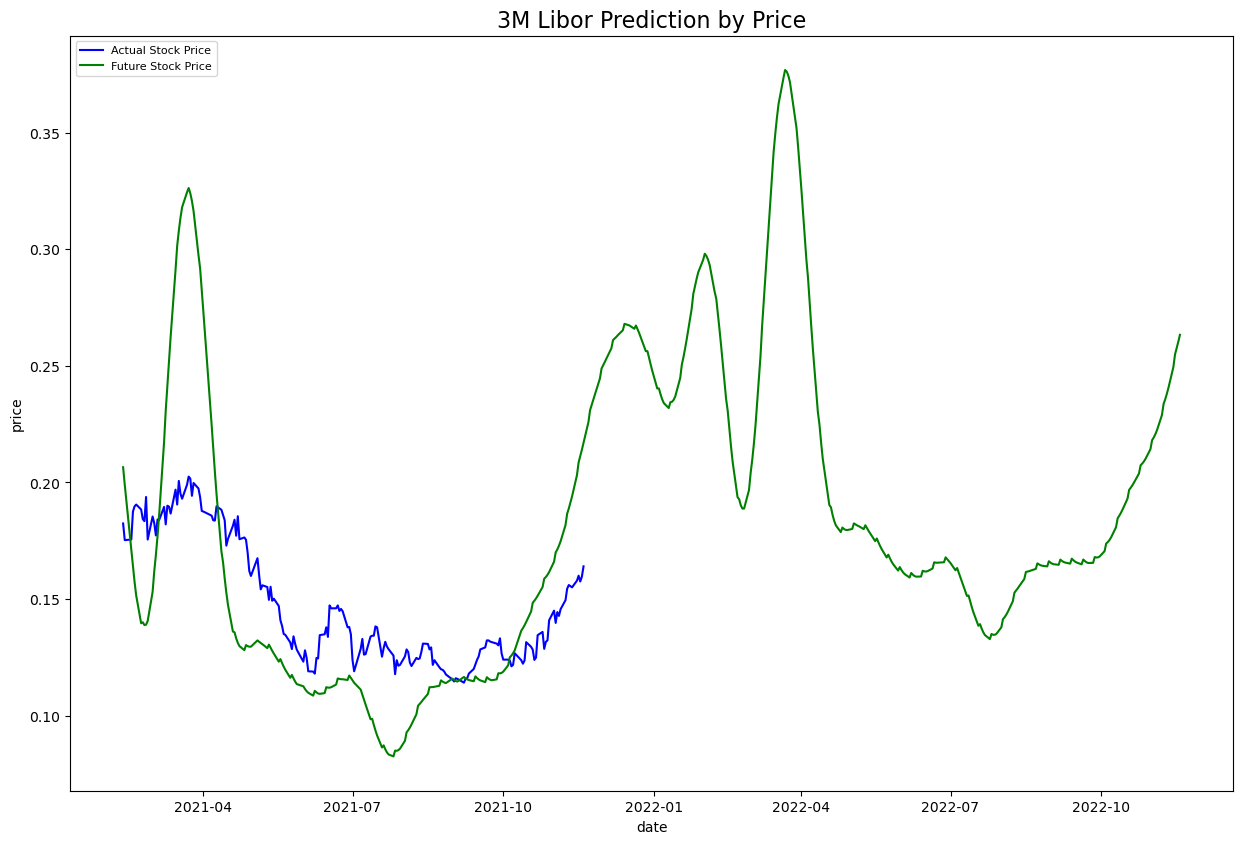

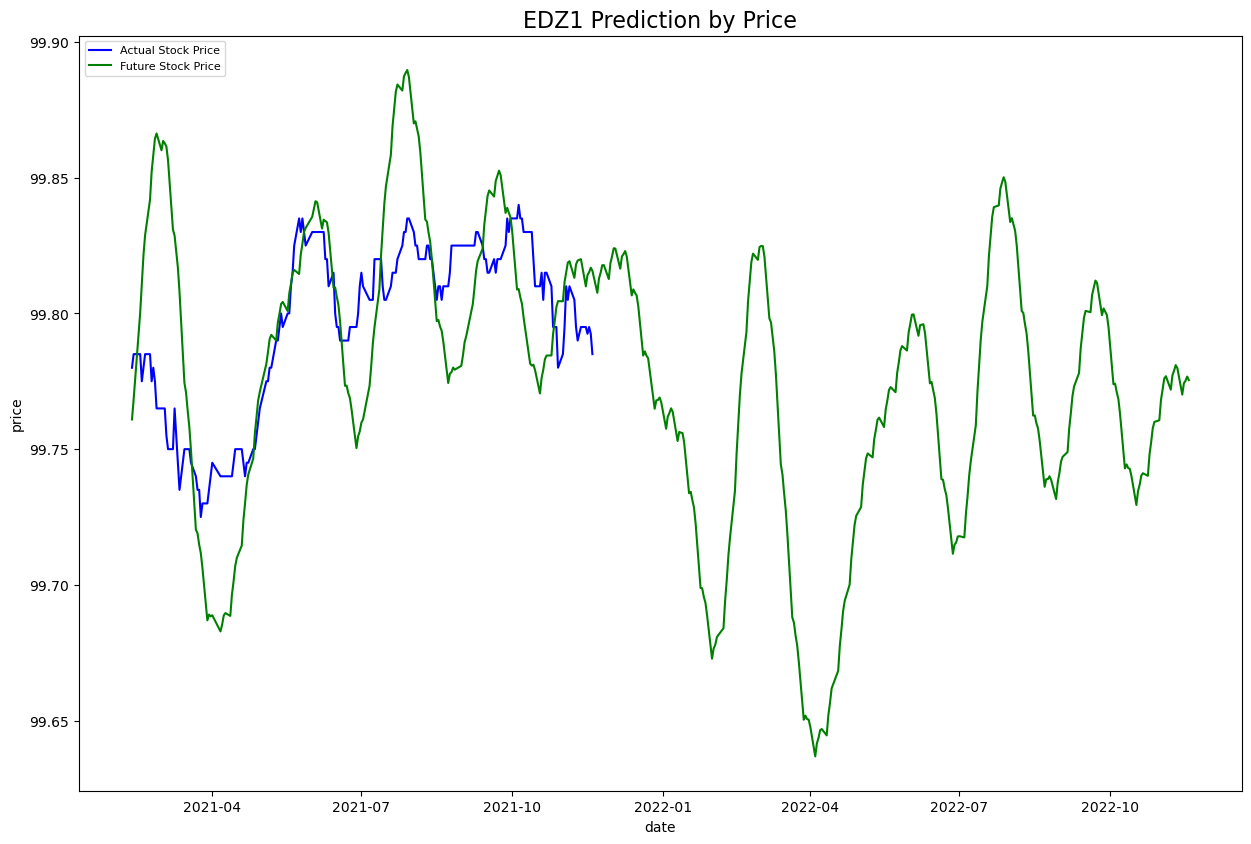

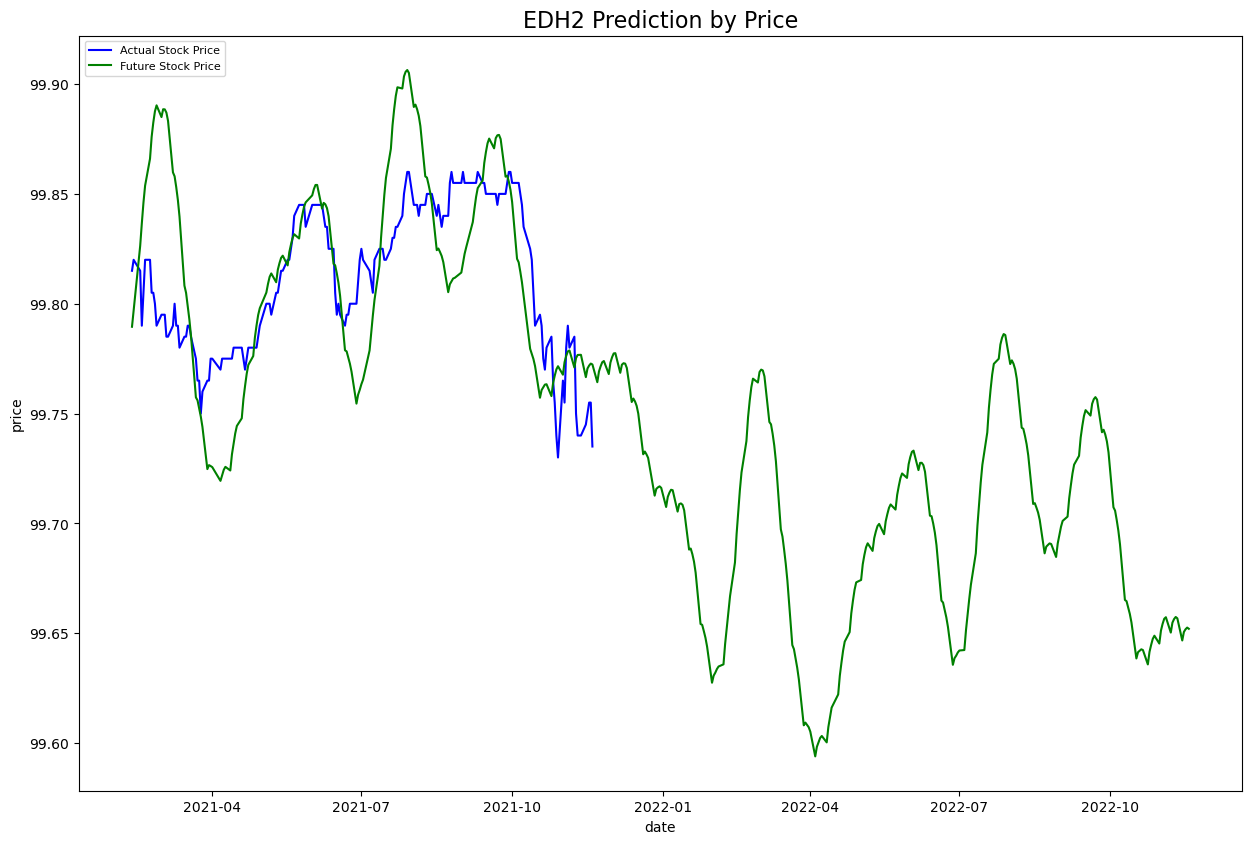

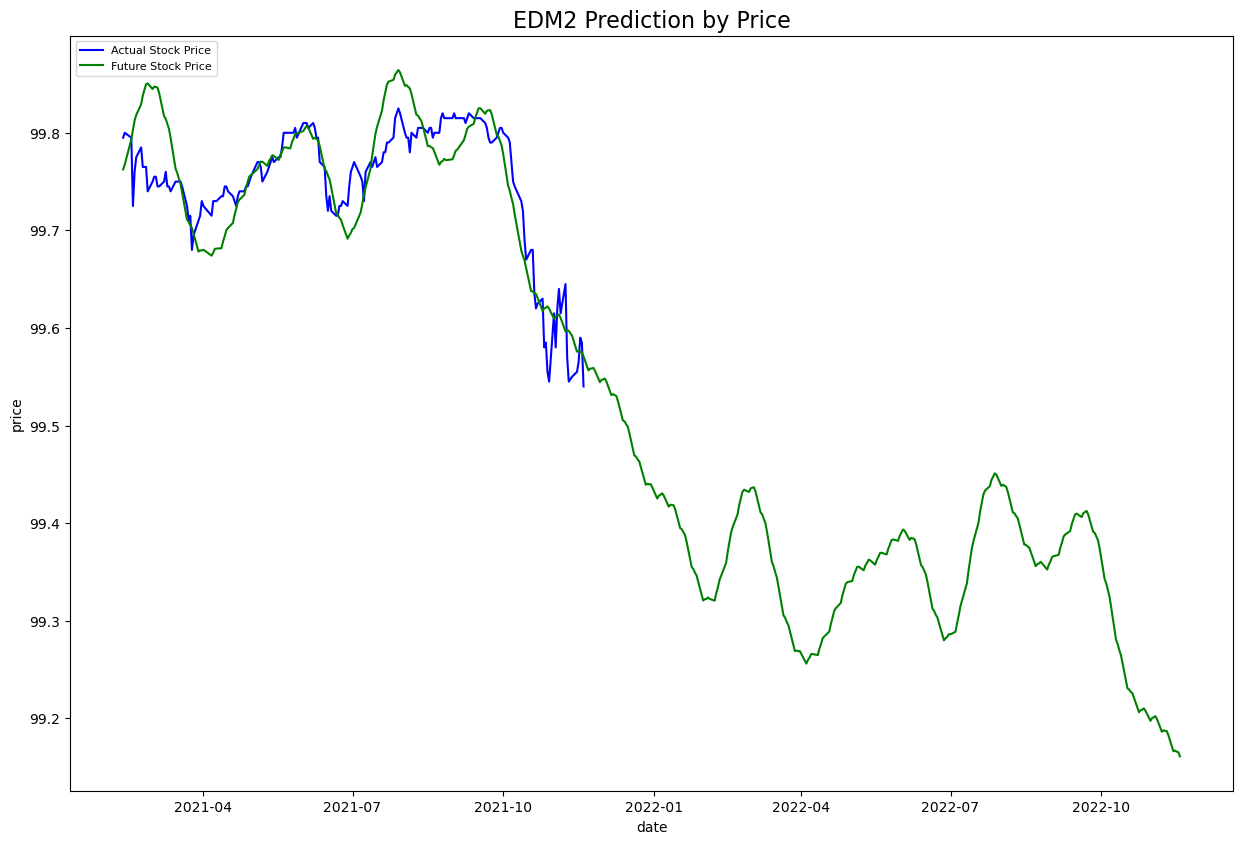

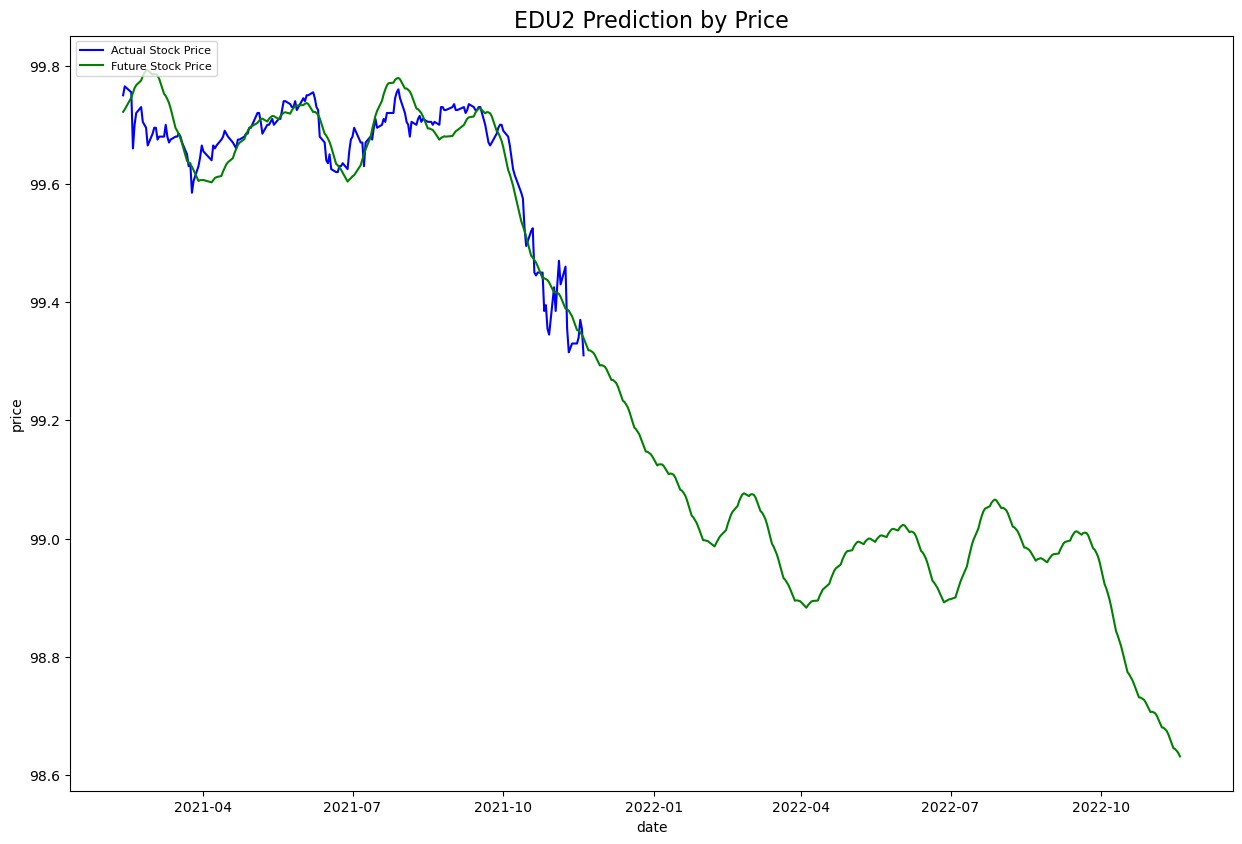

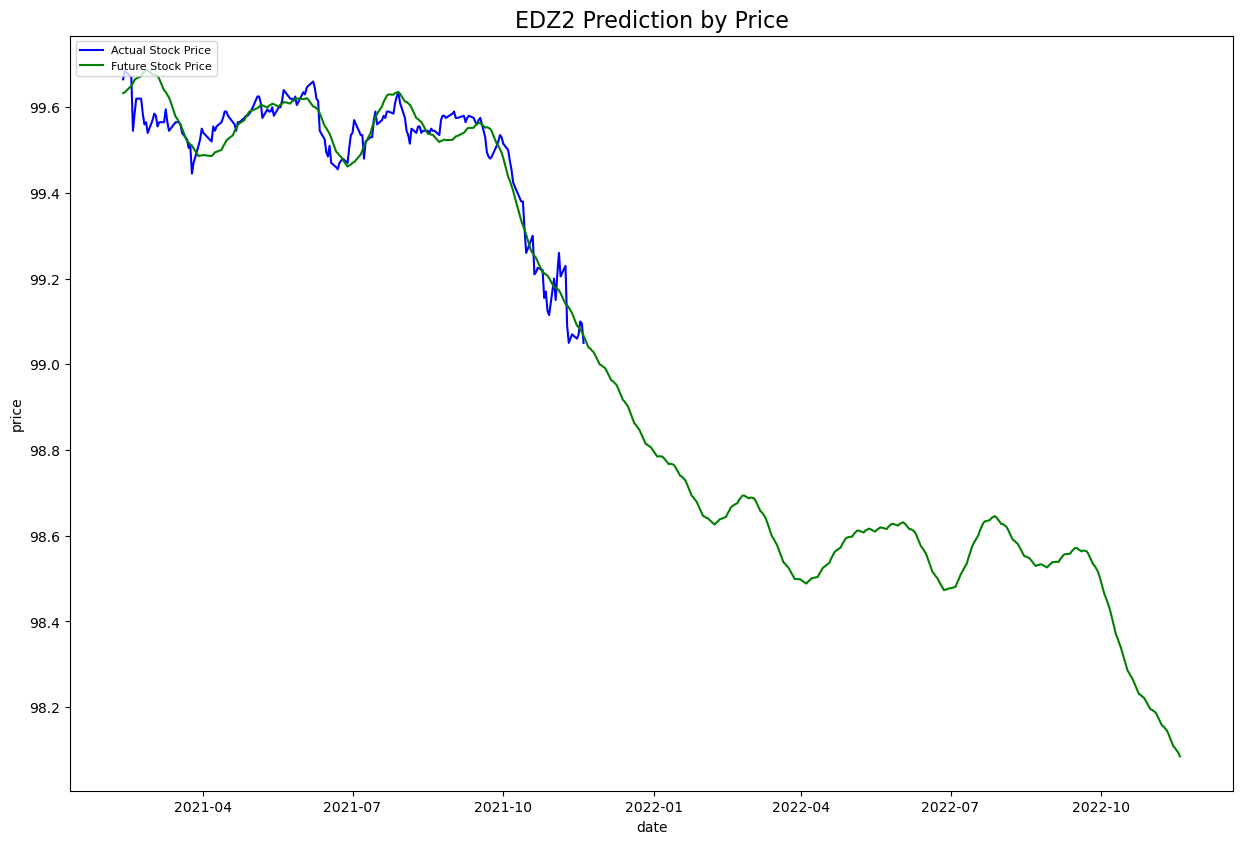

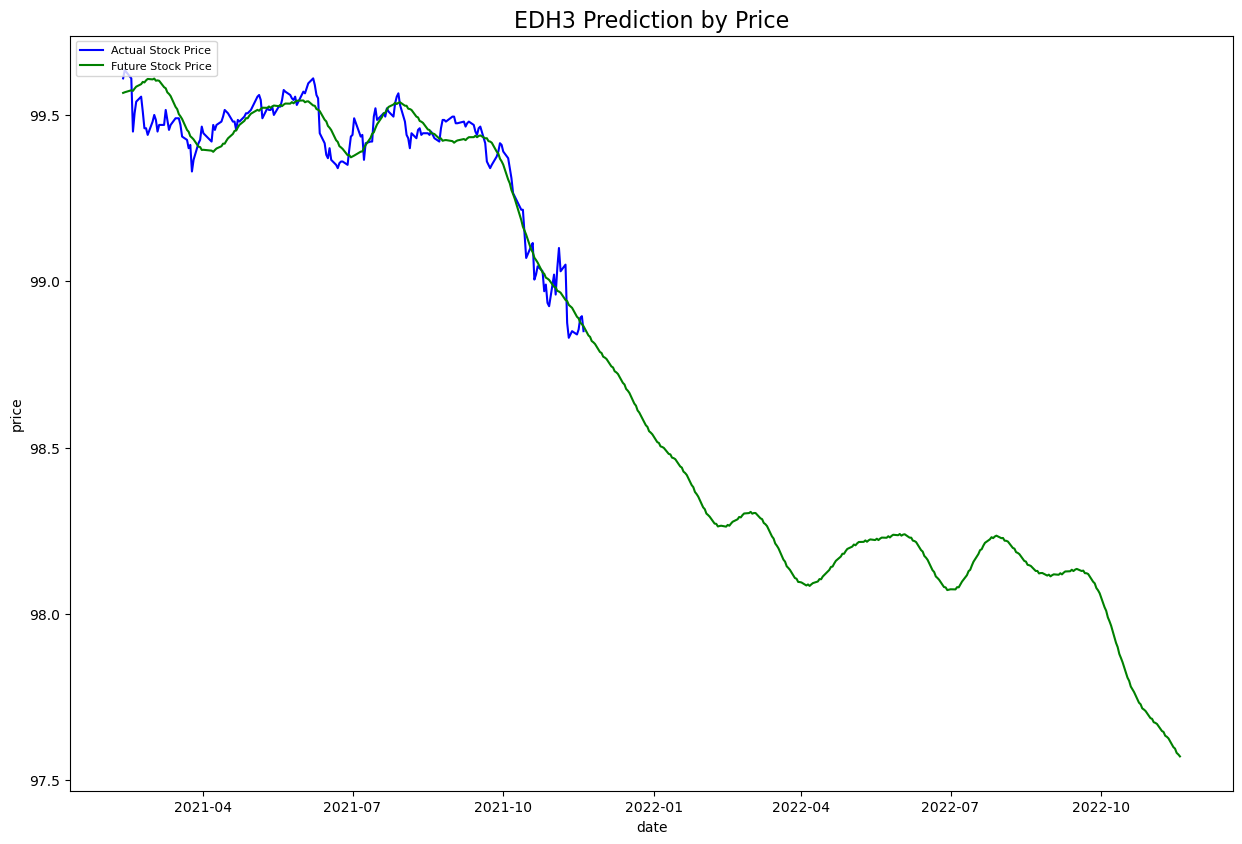

In [14]:
y_list = ['3M Libor', 'EDZ1', 'EDH2', 'EDM2', 'EDU2', 'EDZ2', 'EDH3']
ProphetModel = ProphetModel(MasterDF,y_list)
df, trading, bond = ProphetModel.prophetDataframe()
model = ProphetModel.Model(df, trading, bond)

Optimum number of features: 66
Score with 66 features: 0.999519
Index(['1W Libor', '1M Libor', '2M Libor', '6M Libor', '12M Libor', 'USSA2',
       'USSA3', 'USSA4', 'USSA5', 'USSA6', 'USSA7', 'USSA8', 'USSA9', 'USSA20',
       'USSA30', 'USOSFR2', 'USOSOFR3', 'USOSOFR4', 'USOSOFR5', 'USOSOFR6',
       'USOSOFR7', 'USOSOFR8', 'USOSOFR9', 'USOSOFR10', 'USOSOFR12',
       'USOSOFR15', 'USOSOFR20', 'USOSOFR40', 'USOSOFR50', 'USSWAP2',
       'USSAWP3', 'USSAWP4', 'USSAWP5', 'USSW6', 'USSAWP7', 'USSW8', 'USSW9',
       'USSAWP10', 'USSAWP11', 'USSAWP12', 'USSAWP15', 'USSAWP25', 'USSAWP30',
       'USSAWP50', 'EDZ1', 'EDZ2', 'EDZ3', 'EDZ4', 'EDZ4.1', 'EDH2', 'EDH3',
       'EDH4', 'EDM2', 'EDM3', 'EDU2', 'EDU3', 'EDU4', 'ED2', 'ED3', 'ED4',
       'ED5', 'ED6', 'ED7', 'ED8', 'ED9', 'ED10'],
      dtype='object')
RMSE: 0.040616957370468304
%RMSE:  0.2755818247881899
Optimum number of features: 60
Score with 60 features: 0.999896
Index(['1M Libor', '2M Libor', '3M Libor', '6M Libor', '12M Lib

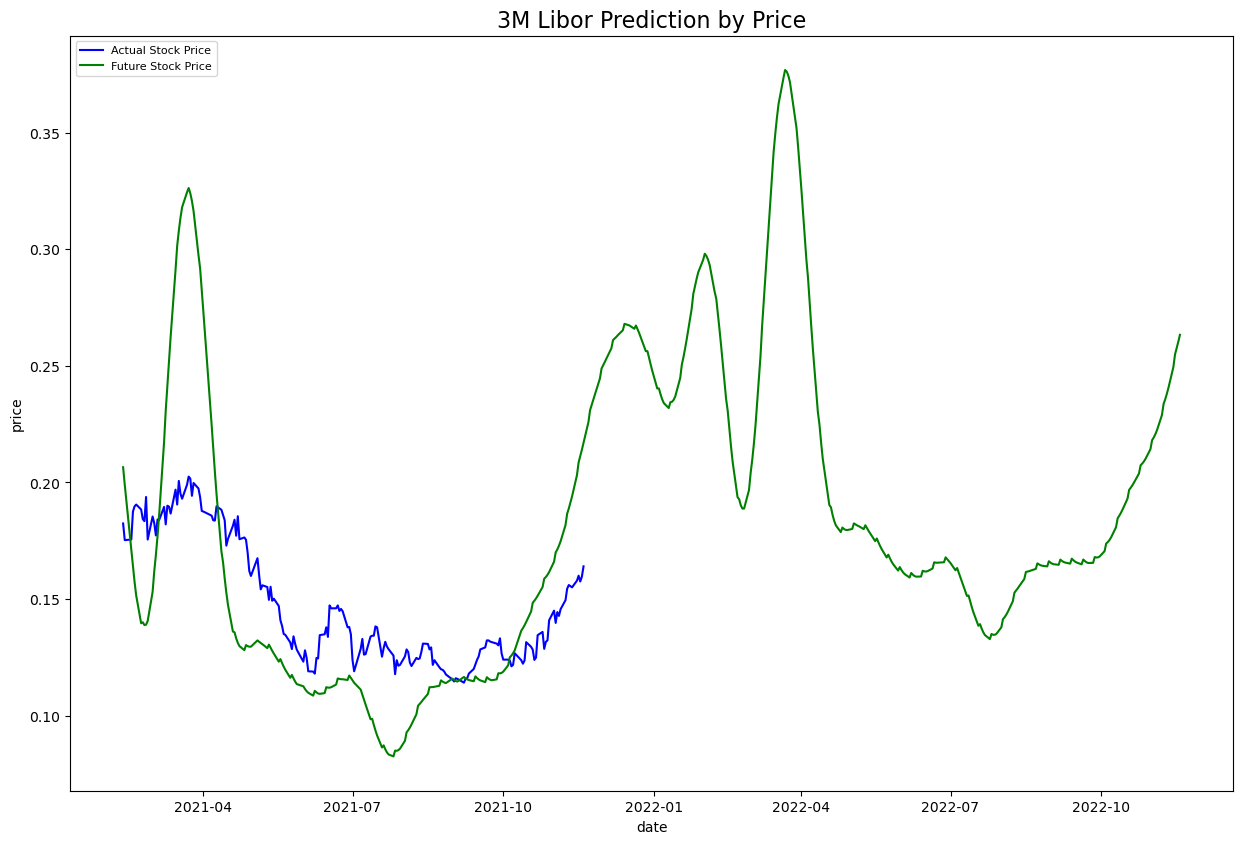

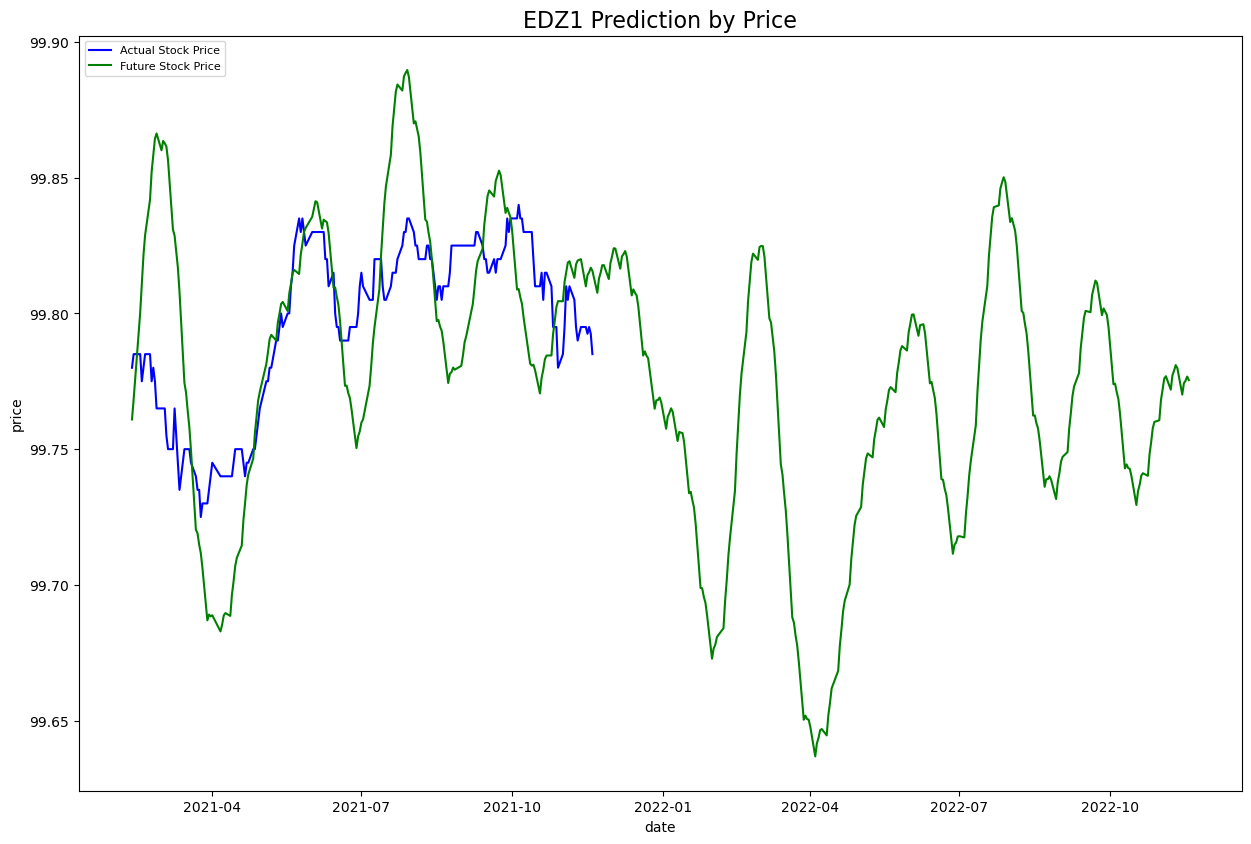

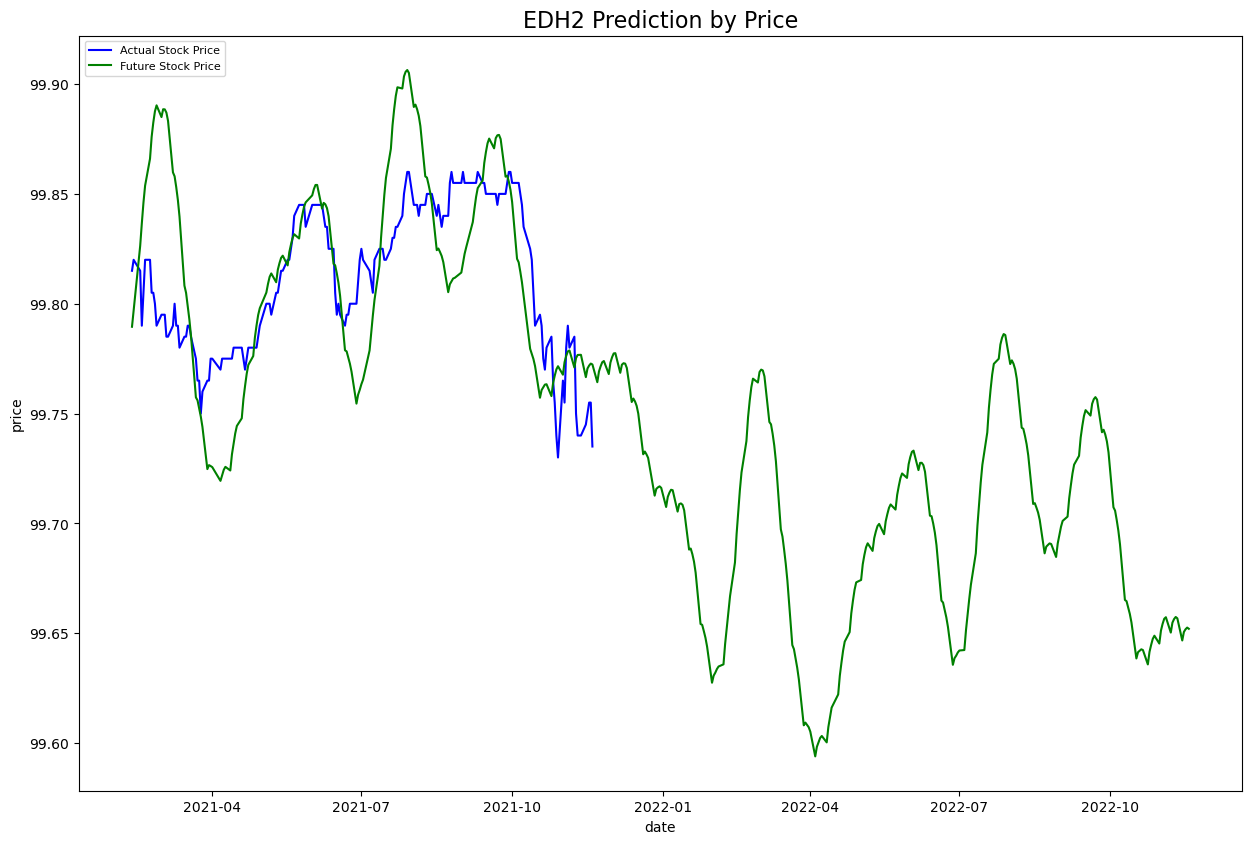

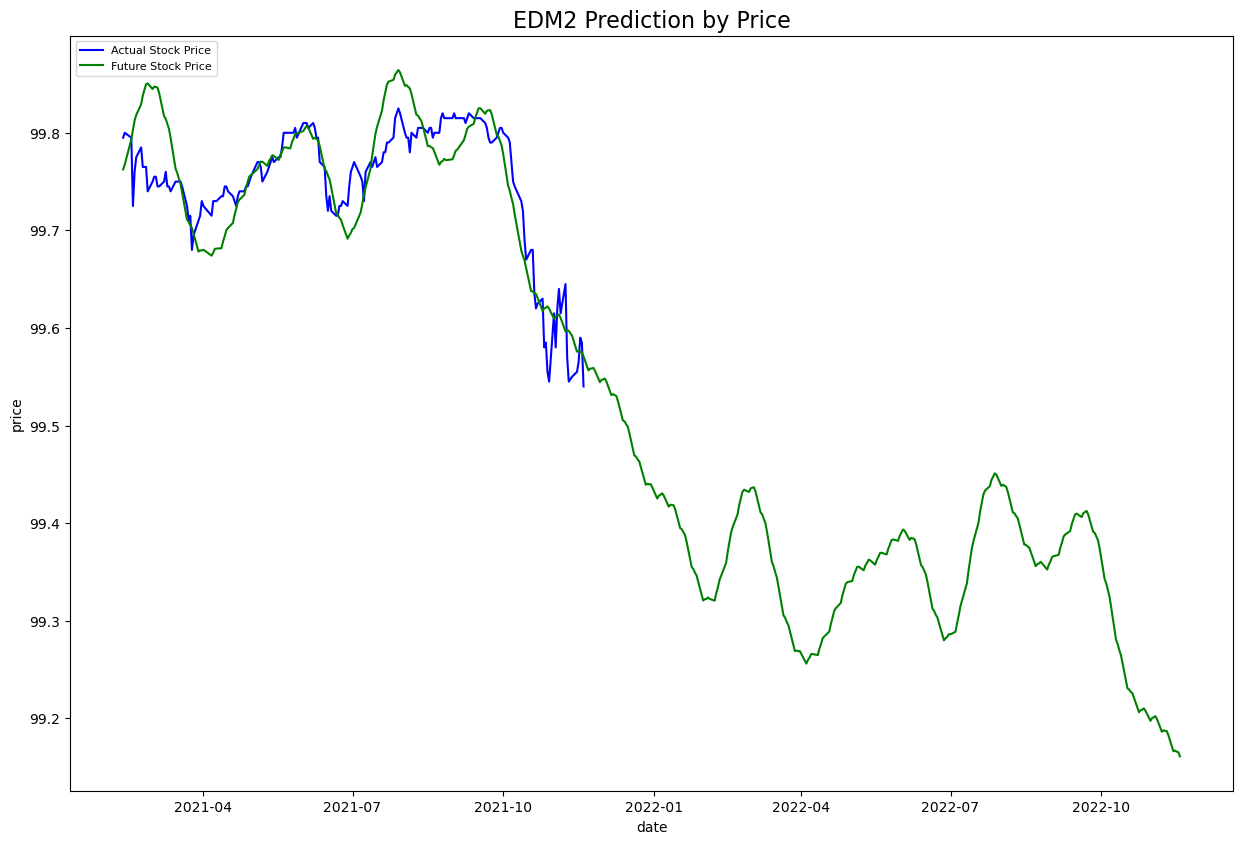

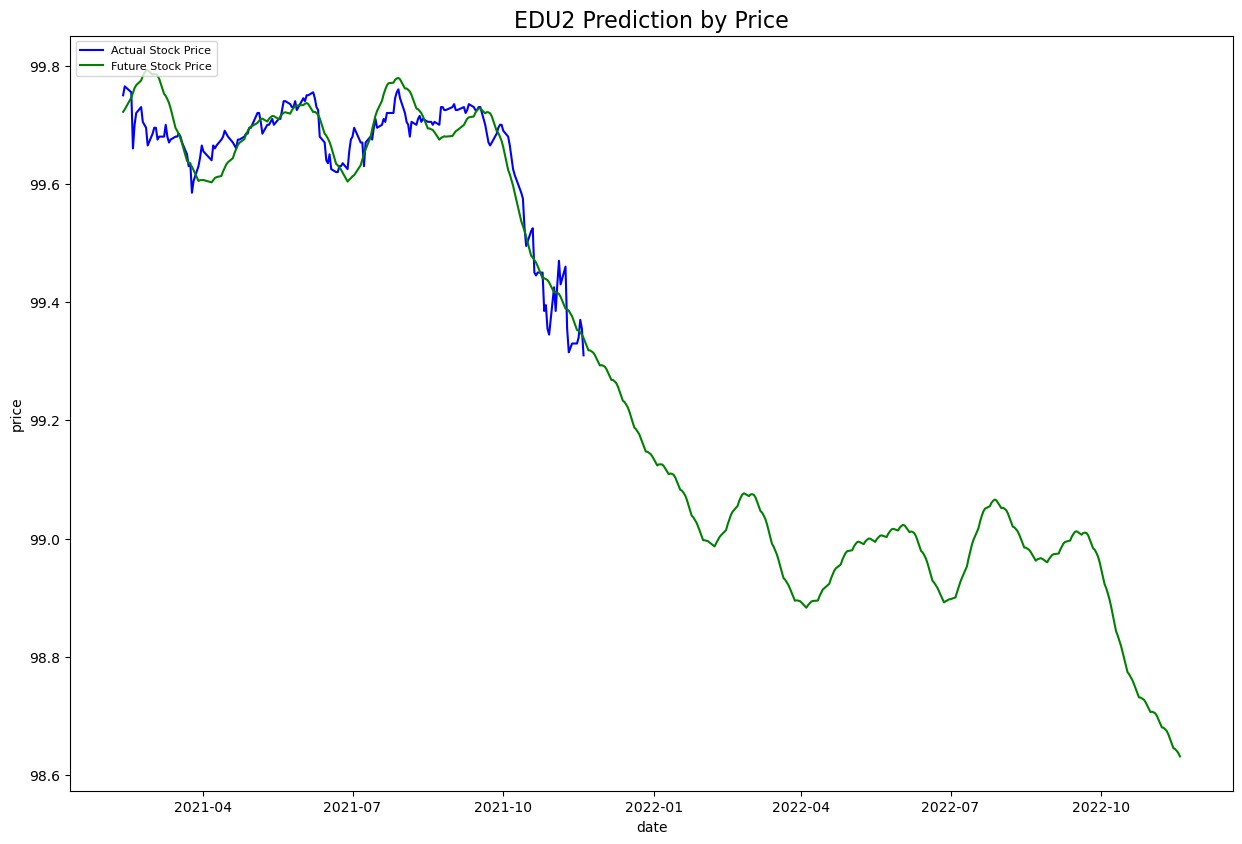

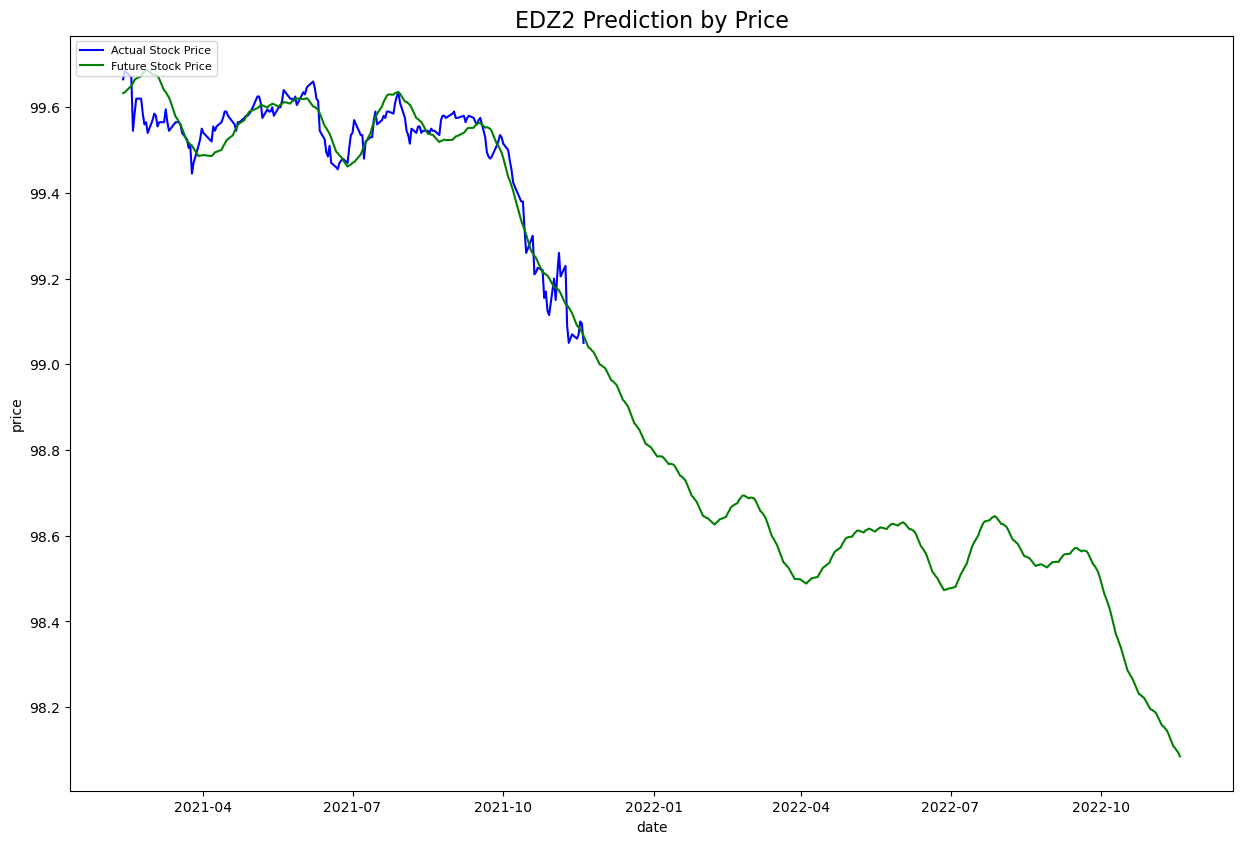

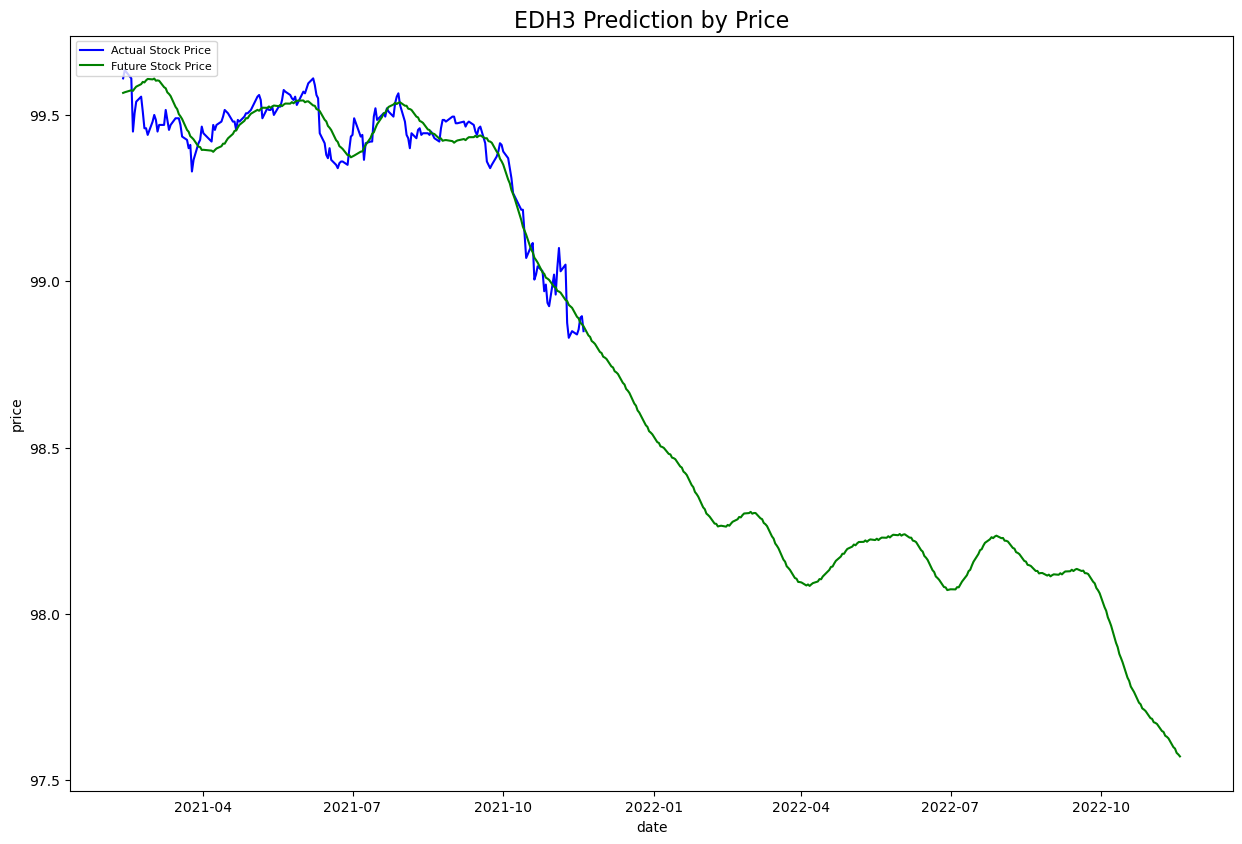

In [11]:
prophet_Df = MasterDF[MasterDF.index >= '2018-01-01'].dropna(axis=1).sort_index()
CME_Bond = mcal.get_calendar('CME_Bond')
trading_days = CME_Bond.schedule(start_date='2012-07-01', end_date='2030-07-10')
#[MasterDF.index >= '2019-06-01']

y_list = ['3M Libor', 'EDZ1', 'EDH2', 'EDM2', 'EDU2', 'EDZ2', 'EDH3']
result = pd.DataFrame()

for y_val in y_list:
    x_vals = prophet_Df.drop(columns = ['Date', y_val])
    y_vals = prophet_Df[y_val]
    
    # scaling later
    scaler = StandardScaler()
    scaled_x_vals = scaler.fit_transform(x_vals)
    x_vals_scaled = pd.DataFrame(scaled_x_vals, index=x_vals.index, columns=x_vals.columns)
    
    #no of features
    nof_list=np.arange(1,x_vals_scaled.shape[1]+1)            
    high_score=0
    #Variable to store the optimum features
    nof=0           
    score_list =[]
    for n in nof_list:
        X_train, X_test, y_train, y_test = train_test_split(x_vals_scaled, y_vals, test_size = 0.2, random_state = 0)
        model = LinearRegression()
        rfe = RFE(model, n_features_to_select=n, step=1)
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        score = model.score(X_test_rfe,y_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            nof = nof_list[n-1]
    print("Optimum number of features: %d" %nof)
    print("Score with %d features: %f" % (nof, high_score))
    
    cols = list(x_vals_scaled.columns)
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, n_features_to_select=nof, step=1)             
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(x_vals_scaled,y_vals)  
    #Fitting the data to model
    model.fit(X_rfe,y_vals)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    print(selected_features_rfe)
    
    prophet_data = pd.concat([y_vals, x_vals_scaled[selected_features_rfe]], axis=1)
    prophet_data = prophet_data.rename(columns = {y_val:'y'})
    prophet_data['ds']= prophet_data.index
    train, test = prophet_data[:int(len(prophet_data)*0.80)], prophet_data[int(len(prophet_data)*0.80):]
    
    # The Prophet class (model)
    fbp = Prophet(daily_seasonality=True) 
    # Fit the model 
    fbp.fit(prophet_data)
    # We need to specify the number of days in future
    # We'll be predicting the full 2021 stock prices
    forecast = fbp.predict(test)
    
    forecast_df = forecast.set_index('ds')
    
    MSE = np.square(np.subtract(test.y,forecast_df.yhat)).mean() 
 
    RMSE = math.sqrt(MSE)
    print(f'RMSE: {RMSE}')
    print("%RMSE: ", RMSE/test['y'].mean())
    
    future = fbp.make_future_dataframe(periods=365, freq='D')
    future = future[future['ds'].isin(trading_days.index)]
    future_forecast2 = fbp.predict(future)
    future_forecast2 = future_forecast2.set_index('ds')
    future_forecast2 = future_forecast2[future_forecast2.index >= '2021-02-11']
    
    plt.figure(figsize=(15,10), dpi=100)
    plt.plot(test.index, test.y, color = 'blue', label='Actual Stock Price')
    plt.plot(future_forecast2.index, future_forecast2.yhat, color = 'green',label='Future Stock Price')
    plt.title(f'{y_val} Prediction by Price', fontsize=16)
    plt.xlabel('date')
    plt.ylabel('price')
    plt.legend(loc='upper left', fontsize=8)
    #plt.savefig(f'./images/prophet_future_price_{y_val}.png')

    result = pd.concat([result, future_forecast2.yhat], axis=1)
    result = result.rename(columns = {'yhat':y_val})

    

In [ ]:
class CurveConstruction:
    
    def __init__(self, lstTenors, curveDF, curveSlice, curveType, color, point):
        # lstTenors = the tenors of the curve that we want to build
        # curveDF = the dataFrame that we contains the specific curve data
        # curveSlice = the time period of the curve that we want to display, (0 = most recent day)
        # curveType = the BBG ID curve that we want to display e.g. the S23 (Eurodollar Swap curve)
        # color of the curve for multiple curves
        self.lstTenors = lstTenors
        self.curveDF = curveDF
        self.curveSlice = curveSlice
        self.curveType = curveType
        self.color = color
        self.point = point
    
    def Plot2DCurve(self):
        curve = self.curveDF.iloc[self.curveSlice]
        #print(curve)
        fig = plt.figure()
        fig.suptitle(f'SWAP Curve Replicating {self.curveType} from Bloomberg ', fontsize=14)
        ax = plt.axes(xlabel=' Tenor in Years',ylabel='Yields as (%)')
        ax.grid(linestyle='--', linewidth=1, color='grey')
        fig.set_figwidth(15)
        fig.set_figheight(5)
        return ax.plot(self.lstTenors,curve,marker=self.point,color=self.color,linewidth=2)

In [ ]:
temp_df = MasterDF.drop(columns=SpotCurve.columns)
prophet_Df = pd.concat([SpotCurve, temp_df], axis=1)
prophet_Df = prophet_Df[prophet_Df.index >= '2018-01-01'].dropna(axis=1).sort_index()


#[MasterDF.index >= '2019-06-01']

y_list = ['3M Libor', 'EDZ1', 'EDH2', 'EDM2', 'EDU2', 'EDZ2', 'EDH3']
result2 = pd.DataFrame()

for y_val in y_list:
    x_vals = prophet_Df.drop(columns = ['Date', y_val])
    y_vals = prophet_Df[y_val]
    
    # scaling later
    scaler = StandardScaler()
    scaled_x_vals = scaler.fit_transform(x_vals)
    x_vals_scaled = pd.DataFrame(scaled_x_vals, index=x_vals.index, columns=x_vals.columns)
    
    #no of features
    nof_list=np.arange(1,x_vals_scaled.shape[1]+1)            
    high_score=0
    #Variable to store the optimum features
    nof=0           
    score_list =[]
    for n in nof_list:
        X_train, X_test, y_train, y_test = train_test_split(x_vals_scaled, y_vals, test_size = 0.2, random_state = 0)
        model = LinearRegression()
        rfe = RFE(model, n_features_to_select=n, step=1)
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        score = model.score(X_test_rfe,y_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            nof = nof_list[n-1]
    print("Optimum number of features: %d" %nof)
    print("Score with %d features: %f" % (nof, high_score))
    
    cols = list(x_vals_scaled.columns)
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, n_features_to_select=nof, step=1)             
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(x_vals_scaled,y_vals)  
    #Fitting the data to model
    model.fit(X_rfe,y_vals)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    print(selected_features_rfe)
    
    prophet_data = pd.concat([y_vals, x_vals_scaled[selected_features_rfe]], axis=1)
    prophet_data = prophet_data.rename(columns = {y_val:'y'})
    prophet_data['ds']= prophet_data.index
    train, test = prophet_data[:int(len(prophet_data)*0.80)], prophet_data[int(len(prophet_data)*0.80):]
    
    # The Prophet class (model)
    fbp = Prophet(daily_seasonality=True) 
    # Fit the model 
    fbp.fit(prophet_data)
    # We need to specify the number of days in future
    # We'll be predicting the full 2021 stock prices
    forecast = fbp.predict(test)
    
    forecast_df = forecast.set_index('ds')
    MSE = np.square(np.subtract(test.y,forecast_df.yhat)).mean() 
 
    RMSE = math.sqrt(MSE)
    print(f'RMSE: {RMSE}')
    print("%RMSE: ", RMSE/test['y'].mean())
    
    future = fbp.make_future_dataframe(periods=365, freq='D')
    future = future[future['ds'].isin(trading_days.index) ]
    future_forecast2 = fbp.predict(future)
    future_forecast2 = future_forecast2.set_index('ds')
    future_forecast2 = future_forecast2[future_forecast2.index >= '2021-02-11']
    
    plt.figure(figsize=(15,10), dpi=100)
    plt.plot(test.index, test.y, color = 'blue', label='Actual Stock Price')
    plt.plot(future_forecast2.index, future_forecast2.yhat, color = 'green',label='Future Stock Price')
    plt.title(f'{y_val} Prediction by Rate', fontsize=16)
    plt.xlabel('date')
    plt.ylabel('price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    #plt.savefig(f'./images/prophet_future_rate_{y_val}.png')

    result2 = pd.concat([result2, future_forecast2.yhat], axis=1)
    result2 = result2.rename(columns = {'yhat':f'{y_val}_value'})

In [ ]:
# curve tenors by Bloomberg classification
I23 = [0.25,0.3,0.5,0.75,1,1.25,1.5,2,3,4,5,6,7,8,9,10,15,20,30,40,50]
I206 = [1/360,7/360,0.25,0.3,0.5,0.75,1]
I203 = [3,4,5,6,7,8,9,10,15,20,25,30]

curveplot1 = CurveConstruction(I23,SpotCurve,0,'Discount Curve I23','blue','o')
curveplot1.Plot2DCurve()

curveplot2 = CurveConstruction(I23,DiscountCurveAdjusted,0,'Discount Curve PCA','blue','o')
curveplot2.Plot2DCurve()

libor = CurveConstruction(I206,LiborCurve,20,'LIBOR Curve I206','blue','o')
libor.Plot2DCurve()

#print(walkfCurve.head(2))
curveplot3 = CurveConstruction(I23,walkfCurveAdjusted,12,'Discount Curve I23','blue','o')
curveplot3.Plot2DCurve()

In [ ]:
pred_futures = FuturesTransform(24/360, 0.0, result)
pred_futuresRates = pred_futures.convertToRate()

pred_forwardRates = pred_futures.HullWhiteConvexityAdjustment(pred_futuresRates)

pred_DiscountCurveCopy = result.drop(["EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"], axis=1)
pred_DiscountCurveCopy = pred_DiscountCurveCopy/100
pred_DiscountCurveAdjusted = pd.concat([pred_DiscountCurveCopy, pred_forwardRates], axis=1)


pred_spotrates = pred_futures.ForwardToSpot(pred_DiscountCurveAdjusted) 
pred_spotrates


In [ ]:
class CurveConstruction2:
    
    def __init__(self, priceDF, rateDF, realDF, date):
        # lstTenors = the tenors of the curve that we want to build
        # curveDF = the dataFrame that we contains the specific curve data
        # curveSlice = the time period of the curve that we want to display, (0 = most recent day)
        # curveType = the BBG ID curve that we want to display e.g. the S23 (Eurodollar Swap curve)
        # color of the curve for multiple curves
        self.priceDF = priceDF
        self.rateDF = rateDF
        self.date = date
        self.realDF = realDF
    
    def Plot2DCurve(self):
        lstTenors = [0.25,0.5,0.75,1,1.25,1.5]
        lsttime = ['3M', '6M', '9M', '12M', '15M', '18M']
        price_curve = self.priceDF[self.priceDF.index == self.date].values.tolist()[0][1:]
        rate_curve = self.rateDF[self.rateDF.index == self.date].values.tolist()[0][1:]
        
        #print(curve)
        plt.figure(figsize=(15,5))
        plt.plot(lstTenors, price_curve, marker='o',linewidth=2, label='Prediced by price')
        plt.plot(lstTenors, rate_curve, marker='o',linewidth=2, label='Prediced by rate')
        
        if self.date in self.realDF.index:
            real_curve = self.realDF[self.realDF.index == self.date].values.tolist()[0][1:]
            plt.plot(lstTenors, real_curve, marker='o',linewidth=2, label='Real value')
            plt.title(f'Predicted and Actual SWAP Curve on {self.date}', fontsize=14)
        else:
            plt.title(f'Predicted SWAP Curve on {self.date}', fontsize=14)
        plt.xticks(ticks=lstTenors, labels=lsttime)
        plt.xlabel('Tenor in Years')
        plt.ylabel('Yields as (%)')
        plt.grid(linestyle='--', linewidth=1, color='grey')
        plt.legend()
        return plt.show()

In [ ]:
future_df = pd.read_csv('walkForward.csv')
future_df.index = pd.to_datetime(future_df['Date'])
future_df = future_df[['3M Libor', 'EDZ1', 'EDH2', 'EDM2', 'EDU2', 'EDZ2', 'EDH3']]
future_df = future_df[future_df.index > '2021-11-19'].dropna(axis=1).sort_index()



actual_futures = FuturesTransform(24/360, 0.0, future_df)
actual_futuresRates = actual_futures.convertToRate()

actual_forwardRates = actual_futures.HullWhiteConvexityAdjustment(actual_futuresRates)

actual_DiscountCurveCopy = future_df.drop(["EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"], axis=1)
actual_DiscountCurveCopy = actual_DiscountCurveCopy/100
actual_DiscountCurveAdjusted = pd.concat([actual_DiscountCurveCopy, actual_forwardRates], axis=1)


actual_spotrates = actual_futures.ForwardToSpot(actual_DiscountCurveAdjusted) 
actual_spotrates

In [ ]:
pred_spotrates.index = pd.to_datetime(pred_spotrates.index)
result2.index = pd.to_datetime(result2.index)
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-11-22')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-11-23')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-11-24')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-11-26')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-11-29')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-11-30')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-12-01')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-12-02')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-12-03')
pred_curveplot.Plot2DCurve()

In [ ]:
pred_curveplot = CurveConstruction2(pred_spotrates, result2, actual_spotrates, '2021-12-06')
pred_curveplot.Plot2DCurve()

In [ ]:
WFcurve = walkfCurveAdjusted.drop(["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"], axis=1)
fbp = pd.concat([pred_spotrates,WFcurve],axis=1)
fbp = fbp.dropna()
#print(fbp.head())
plt.figure(figsize=(15.5, 5))
curveplot3 = CurveConstruction(I23,fbp,0,'Predicted Discount Curve I23','blue','o')
curveplot3.Plot2DCurve()
curveplot1 = CurveConstruction(I23,SpotCurve,0,'Discount Curve I23','blue','o')
curveplot1.Plot2DCurve()
plt.show()